In [1]:
import networkx as nx
import random
import math
import copy
from matplotlib import pyplot as plt

In [2]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return math.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [4]:
def read_instance(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight)
                
        return g

In [5]:
g0 = read_instance(file_path='dj38.tsp')

In [51]:
g0[0]

AtlasView({1: {'weight': 290.99301545433866}, 2: {'weight': 794.0018312710164}, 3: {'weight': 628.7062892741252}, 4: {'weight': 850.0494347752532}, 5: {'weight': 806.3010169484456}, 6: {'weight': 881.9759098638978}, 7: {'weight': 972.873183452112}, 8: {'weight': 991.2811948915838}, 9: {'weight': 437.07375847296123}, 10: {'weight': 1237.9197337359349}, 11: {'weight': 1186.9678817276742}, 12: {'weight': 903.3931728506114}, 13: {'weight': 507.7926916725464}, 14: {'weight': 903.1807647058093}, 15: {'weight': 1178.8418412907574}, 16: {'weight': 1197.2193112261596}, 17: {'weight': 1201.2191072966534}, 18: {'weight': 1205.3779366004712}, 19: {'weight': 901.7446864102617}, 20: {'weight': 760.410092131903}, 21: {'weight': 1032.2892417783694}, 22: {'weight': 943.2215951621602}, 23: {'weight': 1105.6400293858078}, 24: {'weight': 998.6000054737141}, 25: {'weight': 1011.2552138704898}, 26: {'weight': 1527.0919609740627}, 27: {'weight': 1338.9847283010597}, 28: {'weight': 1058.8192781887758}, 29: {'

In [6]:
g1 = read_instance(file_path='att48.tsp')

In [14]:
class Harmony: 
    def __init__(self, g : nx.Graph, cycleList : list):
        if(cycleList == None):
            self.cycle, self.fitness = self.hamiltonian(g)
        else:
            self.cycle, self.fitness = self.calcFitness(cycleList, g)
    
    def __str__(self):
        return ' '.join([str(u) for u in self.cycle]) + f' {self.fitness}'
    
    def __getitem__(self,index):
        return self.cycle[index]
    
    start=0
    
    def hamiltonian(self, g: nx.Graph):
        start = self.start
        cycle = [start]
        cycle_weight = 0
        visited = {start}
        u = start
        while len(visited) != len(g.nodes):
            neighbours = [v for v in g[u] if v not in visited]
            chosen_neighbour = random.choices(neighbours, weights=None, k=1)[0]
            cycle.append(chosen_neighbour)
            visited.add(chosen_neighbour)
            cycle_weight += g[u][chosen_neighbour]['weight']
            u = chosen_neighbour
        
        cycle_weight += g[start][cycle[-1]]['weight']
        return cycle, cycle_weight
    
    def calcFitness(self, cycleList : list, g : nx.Graph):
        i = 0
        fitness = g[cycleList[0]][cycleList[-1]]['weight']
        while i < len(cycleList)-1:
            fitness += g[cycleList[i]][cycleList[i+1]]['weight']
            i+=1
        return cycleList, fitness

In [64]:
def HarmonySearch(
    g: nx.Graph,
    hms: int, #number of harmonies
    rA: float, #harmony memory accepting rate
    rPA: float, #pitch adjusting rate
    maxIterations: int
):
    HarmonyMemory = [Harmony(g, None) for _ in range(hms)]
    c = 0
    bestOfHM = []
    
    for t in range(maxIterations):
        numOfCities = len(g.nodes())
        
        harmonyCycle = []
        for i in range(numOfCities):
             
            if random.random() < rA:
                #chose a value from HM for the variable i (play same harmony)
                harmonyCycle = chooseFromHM(HarmonyMemory, harmonyCycle, i)
                if random.random() < rPA:
                    #adjust the value (improvise on harmony)
                    harmonyCycle = adjustHarmony(harmonyCycle, g)
            else:
                #chose random harmony (improvise)
                harmonyCycle = improvise(harmonyCycle, g)
            
            if len(harmonyCycle) != i+1 : #node doesnt have unvisited neighbor
                break
            
        #accept solution if better than worst
        #(calc fitness and sort hm fitnesses)
        if len(g.nodes) != len(harmonyCycle):
            c+=1
            continue
        
        newHarmony = Harmony(g, harmonyCycle)
        
        HarmonyMemory.sort(key= lambda x : x.fitness, reverse=True)
        
        bestOfHM.append(sum([f.fitness for f in HarmonyMemory[hms-6:hms-1]])/5)
        
        if(newHarmony.fitness < HarmonyMemory[0].fitness):
            HarmonyMemory.remove(HarmonyMemory[0])
            HarmonyMemory.append(newHarmony)
        
        
    print(c)
        
    plt.plot(range(len(bestOfHM)), bestOfHM)
        
    #return best solution
             
    HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
    h = HarmonyMemory[0]
    return h

In [10]:
def chooseFromHM(HarmonyMemory : list, harmony : list, i : int) -> list:
    
    candidates = [HarmonyMemory[u].cycle[i] for u in range(len(HarmonyMemory))]
    
    random.shuffle(candidates)
    
    for c in candidates:
        if c not in harmony:
            harmony.append(c)
            return harmony
    return harmony

In [56]:
def adjustHarmony(harmony : list, g : nx.Graph) -> list:
    
    neighbors = [u for u in g.neighbors(harmony[-1])]
    
    random.shuffle(neighbors)
    
    for u in neighbors:
        if u not in harmony:
            harmony.remove(harmony[-1])
            harmony.append(u)
            return harmony
    return harmony

In [19]:
def improvise(harmony : list, g: nx.Graph) -> list:
    
    candidates = [c for c in g.nodes()]
    
    random.shuffle(candidates)
    
    for c in candidates:
        if c not in harmony:
            harmony.append(c)
            return harmony
    return harmony

8065
34 28 15 1 41 25 38 5 42 22 43 4 20 47 26 17 30 6 0 11 29 27 37 39 18 19 7 2 35 16 10 13 14 45 32 46 8 12 24 36 21 31 44 40 9 23 33 3 116612.9569156506


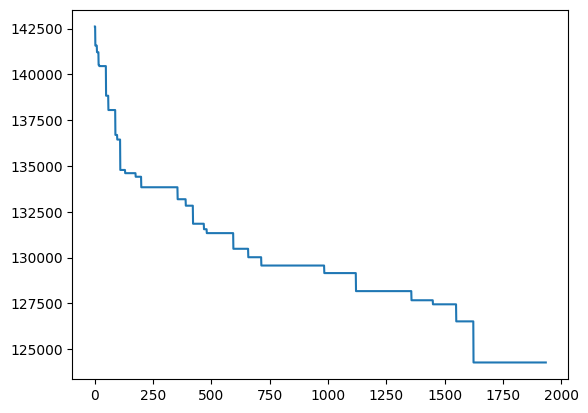

In [36]:
hms = 30
rA = 0.90
rPA = 0.45
maxIterations = 10000
print(HarmonySearch(g1, hms, rA, rPA, maxIterations))

78420
5 30 43 46 27 37 36 45 3 25 44 14 11 22 2 32 8 26 6 34 7 31 47 28 38 20 0 18 16 35 42 29 23 9 10 17 15 39 19 33 4 41 1 24 40 13 12 21 113402.42205310894


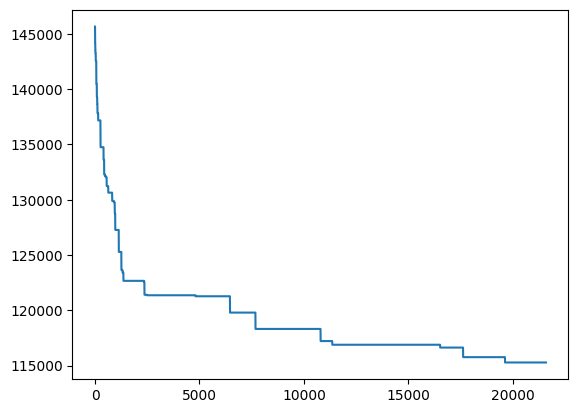

In [39]:
hms = 30
rA = 0.90
rPA = 0.55
maxIterations = 100000
print(HarmonySearch(g1, hms, rA, rPA, maxIterations))

89745
9 27 25 23 21 22 32 35 14 28 31 34 36 29 3 2 33 20 6 5 4 12 18 8 16 30 26 37 7 13 0 10 11 17 24 19 15 1 20837.584927811065


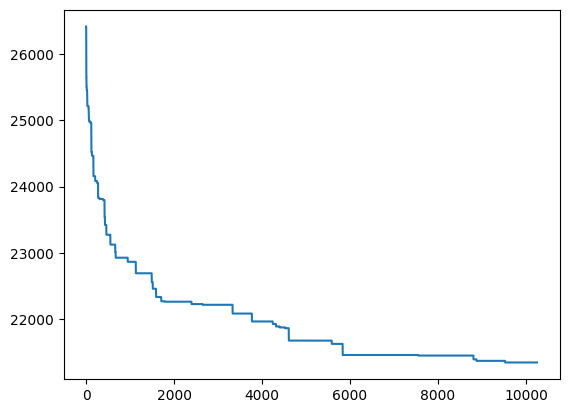

In [38]:
hms = 20
rA = 0.95
rPA = 0.45
maxIterations = 100000
print(HarmonySearch(g0, hms, rA, rPA, maxIterations))